# cmVIP
This notebook runs the cell morphology-based Variant Impact Phenotyping (cmVIP) analysis.

In [1]:
import json
import os
import sys

import pandas as pd
import numpy as np
import umap

from tqdm.auto import tqdm
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Set to "svg" or "png" for non-interactive plots

from zca import ZCA
import correlations as corr
import mvip

## Load Metadata

In [2]:
platemaps = pd.read_csv('inputs/metadata/cytodata/barcode_platemap.csv')
pmaps = pd.concat([pd.read_csv('inputs/metadata/cytodata/platemap/DOC45.46.47.48.txt', sep='\t'),
                   pd.read_csv('inputs/metadata/cytodata/platemap/DOC49.50.51.52.txt', sep='\t')],
                 )

### Filter quality control status

All of our TP53 alleles (including our allele annotated as "wt") actually harbor an inactivating p53 variant. Thus, we flagged such alleles (`qc_status=False`) and discarded them in this analysis because they are wrong perturbations for the purposes of this study.

In [3]:
pmaps = pmaps[pmaps.qc_status]
metadata = pmaps.merge(platemaps, how='inner', left_on='VirusPlateName', right_on='Plate_Map_Name')

## Load Features

In [4]:
key_cols = ["Metadata_Plate", "Metadata_Well"]
deep_features = pd.read_parquet('efn_pretrained_profiles.parquet')

## Define controls

In [5]:
morphology = metadata[['Assay_Plate_Barcode', 'well_position', 'broad_sample', 'pert_type', 'x_mutation_status']].copy()
morphology.columns = ['Metadata_Plate', 'Metadata_Well', 'Metadata_broad_sample', 'pert_type', 'x_mutation_status']
control_def = 'EMPTY'
if control_def == 'EMPTY':
    morphology = morphology[morphology.pert_type!='ctl_vector'].copy()
    morphology['Metadata_broad_sample_type'] = morphology.pert_type.apply(lambda x: 'control' if x == 'EMPTY' else 'trt')
elif control_def == 'NOT_TREATMENT':
    morphology['Metadata_broad_sample_type'] = morphology.pert_type.apply(lambda x: 'control' if x != 'trt_oe' else 'trt')
elif control_def == 'CTL_VECTOR':
    morphology = morphology[morphology.pert_type!='EMPTY'].copy()
    morphology['Metadata_broad_sample_type'] = morphology.pert_type.apply(lambda x: 'control' if x == 'ctl_vector' else 'trt')
morphology['Metadata_broad_sample_type'].value_counts(dropna=False)

trt        4552
control     320
Name: Metadata_broad_sample_type, dtype: int64

## Keep only `MUT` with `WT` and `WT` with `MUT`

In [6]:
def choose_wild_type(options):
    # Choose one WT id out of a list of options
    # If multiple WT, closed WT is preferred 
    wtypes = [opt for opt in options if opt and 'WT.' in opt]
    if not wtypes:
        return None
    if len(wtypes) == 1:
        return wtypes[0]
    # Get first closed wildtype
    return next(filter(lambda x: '.c' in x, wtypes))

def get_allele_stats(s, name):
    wells = len(s)
    controls = (s=='EMPTY').sum()
    s = s[s!='EMPTY']
    alleles = s.str.split('_', expand=True, n=1)
    alleles.columns = ['gene', 'suffix']
    wild_type_map = alleles.groupby('gene')['suffix'].unique().apply(choose_wild_type)
    wild_type_map = wild_type_map.index.astype(str)+'_'+wild_type_map
    wild_type = alleles.gene.map(wild_type_map)
    df = pd.DataFrame({'x_mutation_status': s,
                       'wild_type': wild_type,
                       'gene': alleles.gene})
    
    wt_with_mut = df.wild_type[~df.x_mutation_status.str.contains('WT')].dropna().drop_duplicates()
    wt_no_mut = df.wild_type[~df.wild_type.isin(wt_with_mut)].drop_duplicates()
    mut_no_wt = df.x_mutation_status[df.wild_type.isna() & (~df.x_mutation_status.str.contains('WT'))].drop_duplicates()
    mut_with_wt = df.x_mutation_status[~df.wild_type.isna() & (~df.x_mutation_status.str.contains('WT'))].drop_duplicates()
    return {
    'name': name,
    'wells': wells,
    'controls': controls,
    'alleles': s.nunique(),
    'total_mutants': (~s.drop_duplicates().str.contains('WT')).sum(),
    'total_wild_types': s.drop_duplicates().str.contains('WT').sum(),
    'agg_wild_types': df.wild_type.nunique(),
    'wt_no_mut': wt_no_mut.nunique(),
    'wt_with_mut': wt_with_mut.nunique(),
    'mut_no_wt': mut_no_wt.nunique(),
    'mut_with_wt': mut_with_wt.nunique(),       
    }, wt_with_mut.append(mut_with_wt)

metadata_stats, metadata_alleles = get_allele_stats(metadata.x_mutation_status, 'metadata')
no_ctl_vector_stats, no_ctl_vector_alleles = get_allele_stats(metadata[metadata.pert_type!='ctl_vector'].x_mutation_status, 'no_ctl_vector')
morphology_stats, morphology_alleles = get_allele_stats(morphology.x_mutation_status, 'no_tp53')
pd.DataFrame([
    metadata_stats, no_ctl_vector_stats, morphology_stats
])

,name,wells,controls,alleles,total_mutants,total_wild_types,agg_wild_types,wt_no_mut,wt_with_mut,mut_no_wt,mut_with_wt
0,metadata,6144,320,593,434,159,125,74,51,23,411
1,no_ctl_vector,5632,320,589,430,159,125,74,51,19,411
2,no_tp53,4872,320,501,344,157,124,74,50,19,325


In [7]:
morphology = morphology[morphology.x_mutation_status.isin(morphology_alleles) |
                        (morphology.x_mutation_status=='EMPTY')]
morphology['Metadata_broad_sample_type'].value_counts(dropna=False)

trt        3504
control     320
Name: Metadata_broad_sample_type, dtype: int64

## Merge features and metadata

In [8]:
morphology = morphology.sort_values(by=key_cols)
deep_features = deep_features.sort_values(by=key_cols)

In [9]:
morphology = pd.merge(deep_features[key_cols], morphology, on=key_cols)
deep_features = pd.merge(morphology[key_cols], deep_features, on=key_cols)

morphology.reset_index(drop=True, inplace=True)
deep_features.reset_index(drop=True, inplace=True)
deep_features.info()

deep_feature_matrix = deep_features.select_dtypes(include=["float64"])
deep_feature_matrix.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3824 entries, 0 to 3823
Columns: 6402 entries, Metadata_Plate to 6399
dtypes: float64(6400), int64(1), object(1)
memory usage: 186.8+ MB


(3824, 6400)

## Sphering data

In [10]:
lambda_ = 1e-2
spherer = ZCA(regularization=lambda_)
controls = morphology.Metadata_broad_sample_type == "control"
spherer.fit(deep_feature_matrix[controls])
new_feature_matrix = spherer.transform(deep_feature_matrix)

In [11]:
# Save spherized features with metadata useful for plotting.
dffeats = pd.DataFrame(new_feature_matrix)
dffeats.columns = list(map(str, dffeats.columns))

dffeats['x_mutation_status'] = morphology['x_mutation_status']
alleles = dffeats['x_mutation_status'].str.split('_', expand=True, n=2)
wild_types = alleles.groupby(0)[1].unique().apply(choose_wild_type)
wild_types = wild_types.index.astype(str)+'_'+wild_types
dffeats['wild_type'] = alleles[0].map(wild_types)
dffeats.to_parquet('outputs/spherized_morphology_features.parquet')

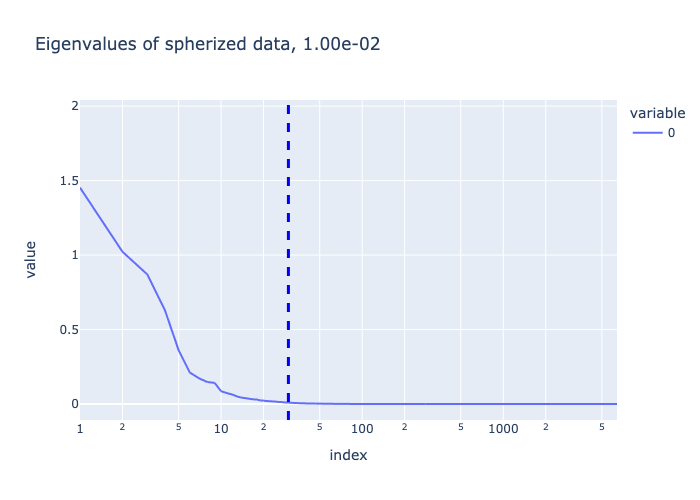

In [12]:
S = spherer.S
lambda_loc = (S>spherer.regularization).sum()
fig = px.line(S, log_x=True,
              title=f'Eigenvalues of spherized data, {spherer.regularization:0.2e}')
fig.add_vline(x=lambda_loc, line_width=3, line_dash="dash", line_color="blue")

## UMap visualization of Sphered data

In [13]:
reducer = umap.UMAP(random_state=0, n_components=2)
reducer.fit(new_feature_matrix)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [14]:
df = pd.DataFrame(reducer.transform(new_feature_matrix), columns=['x', 'y'])
df = pd.concat([df, morphology], axis=1)
aggregate_per_allele = True
if aggregate_per_allele:
    df = df.groupby('x_mutation_status', as_index=False).agg(x=pd.NamedAgg(column="x", aggfunc='median'),
                                                             y=pd.NamedAgg(column="y", aggfunc='median'),
                                                             count=pd.NamedAgg(column="x", aggfunc='count')
                                                            )
df['Gene'] = df['x_mutation_status'].str.split('_', expand=True)[0]

In [15]:
def get_perturbation(s):
    if s == 'EMPTY':
        return 'EMPTY'
    if '_WT.' in s:
        return 'REF'
    else:
        return 'VAR'
df['perturbation'] = df.x_mutation_status.apply(get_perturbation)
df = df.copy()
df['x_mutation_status'] = df['x_mutation_status'].str.replace(r'WT.[oc]', 'REF', regex=True)

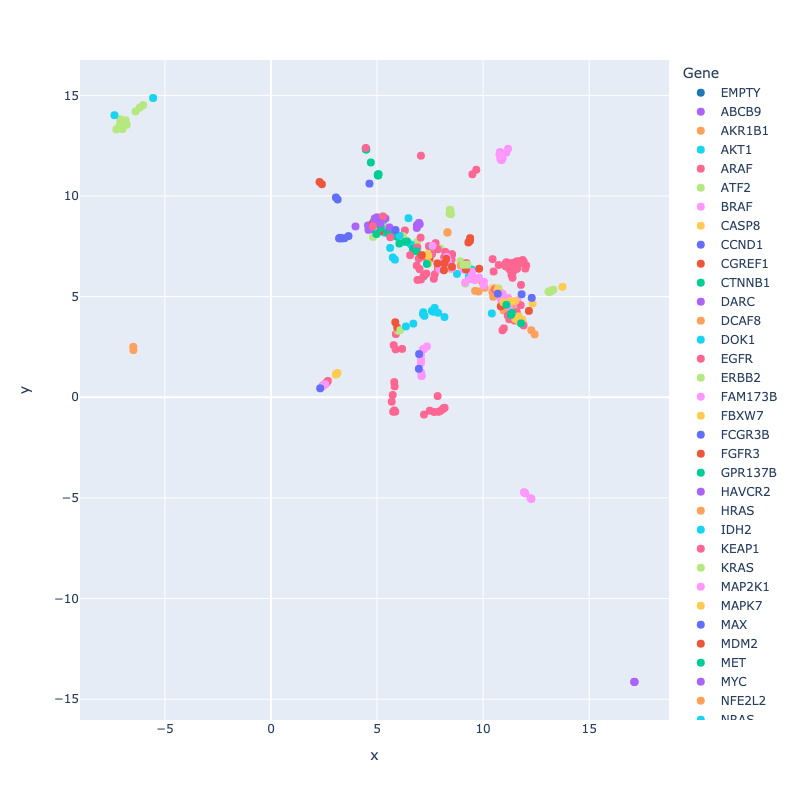

In [16]:
cmap_type = {"EMPTY": '#1f77b4', 'REF':'#2CA02C', 'VAR': '#FF7F0E'}

fig = px.scatter(df, x='x', y='y', color='Gene',
                 title='', #opacity=0.7,
                 category_orders={'perturbation': ['VAR', 'REF', 'EMPTY'],
                                  'Gene': ['EMPTY'] + df.Gene.sort_values().tolist(),
                                 },
                 hover_name='x_mutation_status',
                 color_discrete_map=cmap_type,
                 width=800,
                 height=800
                )
fig.update_traces(marker_size=8)
fig

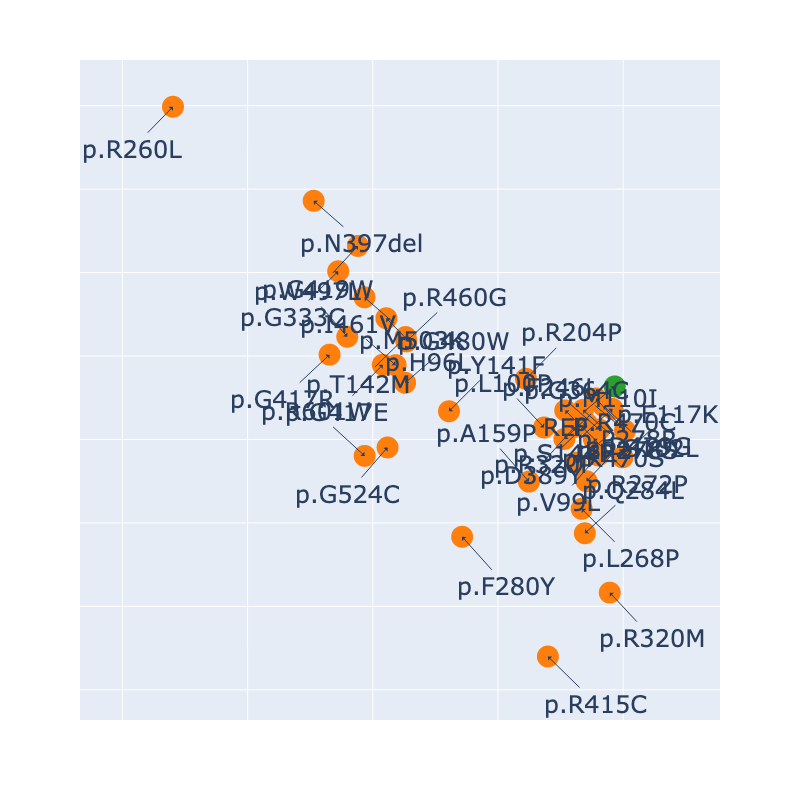

In [17]:
gene_to_plot = 'KEAP1'
plotable = df[df.x_mutation_status.str.contains(gene_to_plot) &\
              ~df.x_mutation_status.str.contains('WT.o')].copy().sample(frac=0.8)
plotable['x_mutation_status'] = plotable['x_mutation_status'].str.replace(r'WT.[oc]', 'REF', regex=True)
fig = px.scatter(plotable, x='x', y='y', color='perturbation', #opacity=0.7,
                 title='',
                 category_orders={'perturbation': ['EMPTY', 'VAR',  'REF'],
                                  'Gene': ['EMPTY'] + df.Gene.sort_values().tolist(),
                                 },
                 hover_name='x_mutation_status',
                 color_discrete_map=cmap_type,
                 width=800,
                 height=800
                )

fig.update_traces(marker_size=22)

for i, row in plotable.iterrows():
    fig.add_annotation(
            x=row['x'], y=row['y'],
            ax=np.sign(np.random.choice([-1, 1]))*np.random.randint(40, 50),
            ay=-np.sign(np.random.choice([-1, 1]))*np.random.randint(40, 50),
            text=row['x_mutation_status'].split('_', 2)[1],
            showarrow=True,
            font_size=24,
            arrowhead=1)
fig.update_yaxes(showticklabels=False, title='')
fig.update_xaxes(showticklabels=False, title='')
fig.update_layout(showlegend=False)

# Replicate correlation analysis

In [18]:
A = new_feature_matrix #new_feature_matrix deep_feature_matrix
corr_matrix = corr.correlation_matrix(A, 0)

In [19]:
treated_samples = morphology[morphology.Metadata_broad_sample_type == "trt"]
null_treatments = corr.null_distribution(treated_samples.index, corr_matrix, 8, repeats=1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.60it/s]


In [20]:
treatments = treated_samples["Metadata_broad_sample"].unique()
treat_correlation = corr.fraction_strong_test(treated_samples, treatments, corr_matrix, null_treatments, "Metadata_broad_sample", 8)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 1164.68it/s]

Treatments tested: 375
At 95th percentile of the null
Fraction strong: 83.20%
Null threshold: 0.4381


In [21]:
null_th_treatment = null_treatments[int(0.95*len(null_treatments))]
fraction_strong = np.sum([m > null_th_treatment for m in treat_correlation.values()])/len(treat_correlation)

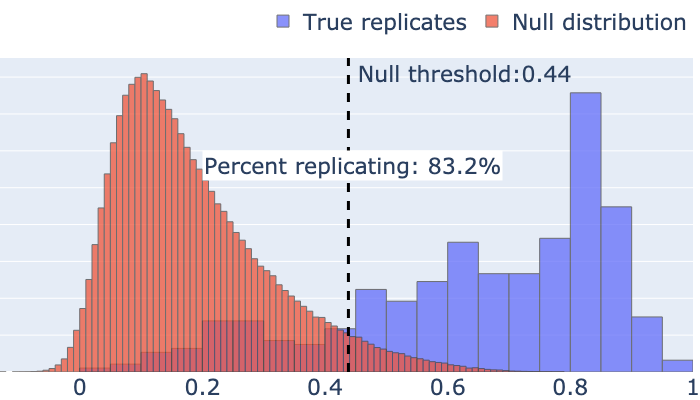

In [22]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=pd.Series(treat_correlation), 
                           nbinsx=20, 
                           histnorm='probability density',
                           name='True replicates'))
fig.add_trace(go.Histogram(x=pd.Series(null_treatments),
                           nbinsx=100,
                           histnorm='probability density',
                           name='Null distribution'))
fig.update_layout(barmode='overlay')#, title='Median correlation distribution of treatment samples')
fig.add_vline(x=null_th_treatment, line_width=3, line_dash="dash", line_color="black",
              annotation_text=f' Null threshold:{null_th_treatment:0.2}', annotation_position="top right")
fig.update_traces(opacity=0.75, marker_line_width=1)
fig.update_layout(height=400, margin=dict(l=0, r=0, t=0, b=0))
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.05,
    xanchor="right",
    x=1
))
fig.update_layout(
    font=dict(
        size=22,
    )
)
fig.update_yaxes(showticklabels=False)

fig.add_annotation(text=f'Percent replicating: {fraction_strong:0.1%}', 
                   x=0.2, y=2.8, showarrow=False,
                   bgcolor="#ffffff",
                   xanchor='left')

fig

In [23]:
control_samples = morphology[morphology.Metadata_broad_sample_type == "control"]
null_controls = corr.null_distribution(control_samples.index, corr_matrix, 8, repeats=1000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.19it/s]


In [24]:
controls = control_samples["Metadata_Well"].unique()
controls_correlation = corr.fraction_strong_test(control_samples, controls, corr_matrix, null_controls, "Metadata_Well", 8)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1556.85it/s]

Treatments tested: 34
At 95th percentile of the null
Fraction strong: 76.47%
Null threshold: 0.0295


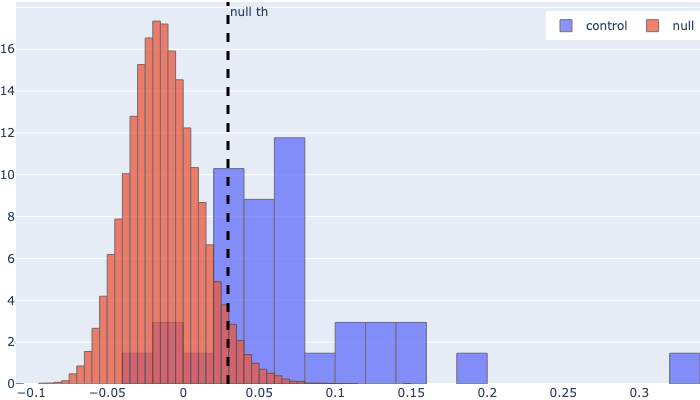

In [25]:
fig = go.Figure()
null_th_control = null_controls[int(0.95*len(null_controls))]

fig.add_trace(go.Histogram(x=pd.Series(controls_correlation), 
                           nbinsx=20, 
                           histnorm='probability density',
                           name='control'))
fig.add_trace(go.Histogram(x=pd.Series(null_controls),
                           nbinsx=100,
                           histnorm='probability density',
                           name='null'))
fig.update_layout(barmode='overlay')#, title='median correlation distribution of control samples')
fig.update_traces(opacity=0.75, marker_line_width=1)
fig.add_vline(x=null_th_control, line_width=3, line_dash="dash", line_color="black",
              annotation_text='null th')
fig.update_layout(height=400, margin=dict(l=0, r=0, t=0, b=0))
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=0.90,
    xanchor="right",
    x=1))

# Variant for single mutation

In [26]:
allele_mask = (morphology["x_mutation_status"] == "ARAF_p.S214F")
wild_type_mask = (morphology["x_mutation_status"] == "ARAF_WT.c")
controls_mask = (morphology["pert_type"] == "EMPTY")
allele_index = morphology[allele_mask].index
wild_type_index = morphology[wild_type_mask].index

In [27]:
allele_corr_matrix = corr.sample_rectangular_matrix(allele_index, allele_index, corr_matrix)
wild_type_corr_matrix = corr.sample_rectangular_matrix(wild_type_index, wild_type_index, corr_matrix)
cross_corr_matrix = corr.sample_rectangular_matrix(wild_type_index, allele_index, corr_matrix)
control_allele_matrix = corr.allele_to_control_matrix(allele_index, morphology, "Metadata_Plate", controls_mask, 20, corr_matrix)
control_wild_type_matrix = corr.allele_to_control_matrix(wild_type_index, morphology, "Metadata_Plate", controls_mask, 20, corr_matrix)

matrices = [control_allele_matrix, allele_corr_matrix, cross_corr_matrix, wild_type_corr_matrix, control_wild_type_matrix]
samples = ["MUT_CTL", "MUT_MUT", "MUT_WT", "WT_WT", "WT_CTL"]

In [28]:
row = np.median(cross_corr_matrix, axis=0)
col = np.median(cross_corr_matrix, axis=1)
cross_corr_median = np.concatenate([row, col])
dots = pd.DataFrame()
dots = dots.append( [{"Sample":"WT_CTL","Correlation":k} for k in np.median(control_wild_type_matrix, axis=1)] )
dots = dots.append( [{"Sample":"WT_WT","Correlation":k} for k in corr.correlation_median_row(wild_type_corr_matrix)] )
dots = dots.append( [{"Sample":"MUT_WT","Correlation":k} for k in cross_corr_median] )
dots = dots.append( [{"Sample":"MUT_MUT","Correlation":k} for k in corr.correlation_median_row(allele_corr_matrix)] )
dots = dots.append( [{"Sample":"MUT_CTL","Correlation":k} for k in np.median(control_allele_matrix, axis=1)] )

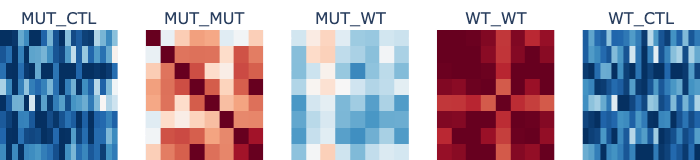

In [29]:
fig = make_subplots(rows=1, cols=5, subplot_titles=samples)
zranges = {'zmin': dots.Correlation.min(),
           'zmax': dots.Correlation.max()}

for i, matrix in enumerate(matrices, 1):
    hmap = go.Heatmap(z=matrix, colorscale='RdBu_r', **zranges)
    fig.add_trace(hmap, row=1, col=i)
fig.update_traces(showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False, autorange='reversed')
fig.update_layout(height=160, margin=dict(l=0, r=0, t=30, b=0))

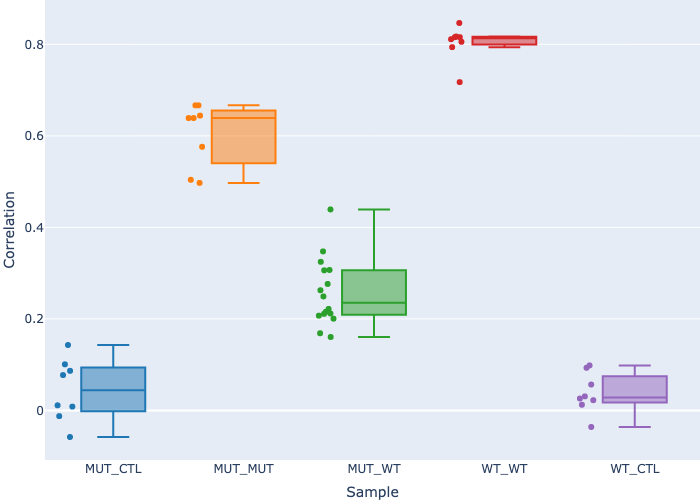

In [30]:
PYPLT_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                '#bcbd22', '#17becf']
fig = px.box(dots, x='Sample', y='Correlation', color='Sample',
             points='all', color_discrete_sequence=PYPLT_COLORS,
             category_orders={'Sample': samples}
            )
fig.update_layout(showlegend=False,
                  margin=dict(l=0, r=0, t=0, b=0)
                 )

# Example Kruskal-Wallis test

In [31]:
# Using all values of the matrices to compute the distributions
self_corr_upper = corr.sample_upper_triangle(allele_index, corr_matrix)
print("H_0: ", mvip.H0)
pvalue = mvip.kruskal_wallis_test(self_corr_upper, control_allele_matrix)
print("pvalue",pvalue)
if pvalue < 0.05: print("Reject H_0")
else: print("Accept H_0")

H_0:  There is no difference between replicate self correlation and control correlation
pvalue 4.3661279526873136e-17
Reject H_0


In [32]:
# Using the median rows of the matrices to represent the distributions
self_corr_upper = corr.sample_upper_triangle(allele_index, corr_matrix)
print("H_0: ", mvip.H0)
pvalue = mvip.kruskal_wallis_on_medians(allele_corr_matrix, control_allele_matrix)
print("pvalue", pvalue)
if pvalue < 0.05: print("Reject H_0")
else: print("Accept H_0")

H_0:  There is no difference between replicate self correlation and control correlation
pvalue 0.0007637037391315315
Reject H_0


# Cell morphology VIP

In [33]:
print(len(morphology), corr_matrix.shape, "Alleles:",len(morphology["x_mutation_status"].unique()))
alleles = morphology["x_mutation_status"].unique()
alleles = [a for a in alleles if a.find("WT") == -1]

print("Number of mutants:",len(alleles))

3824 (3824, 3824) Alleles: 376
Number of mutants: 326


In [34]:
treated_samples = morphology[morphology.Metadata_broad_sample_type == "trt"]
null_treatments = corr.null_distribution(treated_samples.index, corr_matrix, 8, repeats=1000)
null_treatments = null_treatments[0:1000]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.51it/s]


In [35]:
images_dir = 'outputs/images/morphology/'
os.makedirs(images_dir, exist_ok=True)
mvip_test = mvip.Morphology_VIP_CNN_Features(morphology, corr_matrix, treatment_samples=8, 
                                             perturbation_field="x_mutation_status",
                                             control_samples=20)
results = mvip_test.test_allele_set(alleles, create_images=True, null_distribution=null_treatments,
                                    images_dir=images_dir)
results = mvip_test.adjust_pvalues(results, Q=0.05)
results.to_csv("outputs/benchmark_results.csv", index=False)
results

No wild type for: EMPTY


,wild_type,wt_samples,mutant,mut_samples,impact_test,strength_test,directionality_test,power_test,is_sig_impact_test,adjusted_impact_test,is_sig_strength_test,adjusted_strength_test,is_sig_power_test,adjusted_power_test,prediction
0,STC2_WT.c,8.0,STC2_p.N59I,8.0,0.000008,0.006323,0.0,1.777281e-07,True,0.000043,True,0.014172,True,2.416805e-07,LOF
1,RBM45_WT.c,8.0,RBM45_p.R81S,8.0,0.000062,0.000778,0.0,6.653723e-12,True,0.000191,True,0.002717,True,2.419621e-11,LOF
2,EGFR_WT.c,8.0,EGFR_p.K754I,8.0,0.002712,0.004574,0.0,6.613815e-12,True,0.004429,True,0.010696,True,2.419621e-11,LOF
3,PIK3R3_WT.c,8.0,PIK3R3_p.P127L,8.0,0.033015,0.035692,0.0,7.593887e-12,True,0.042078,False,0.057711,True,2.419621e-11,COF
4,KEAP1_WT.c,8.0,KEAP1_p.A159P,8.0,0.000151,0.000778,0.0,6.981598e-12,True,0.000359,True,0.002717,True,2.419621e-11,LOF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,MET_WT.c,8.0,MET_p.F1341L,8.0,0.003643,0.006323,1.0,1.923367e-02,True,0.005692,True,0.014172,True,2.133427e-02,GOF
321,RIT1_WT.c,8.0,RIT1_p.Q40L,8.0,0.000007,0.000778,0.0,3.420098e-02,True,0.000043,True,0.002717,True,3.729973e-02,LOF
322,ERBB2_WT.c,8.0,ERBB2_p.S418T,8.0,0.000016,0.207578,1.0,8.751288e-10,True,0.000059,False,0.275359,True,1.473662e-09,COF
323,ATF2_WT.c,8.0,ATF2_p.A481V,8.0,0.002794,0.293622,1.0,3.402556e-10,True,0.004517,False,0.369872,True,6.319033e-10,COF


In [36]:
signal_strength = {}
treatments = morphology["x_mutation_status"].unique()
for trt in treatments:
    index = morphology["x_mutation_status"] == trt
    median = corr.median_correlation(morphology[index].index, corr_matrix)
    signal_strength[trt] = median

with open('outputs/signal_strength_cp.json', 'w') as fp:
    json.dump(signal_strength, fp)

# False positives analysis

In [37]:
fp_wild_types = ['EGFR_WT.c',
 'EGFR_p.L858R',
 'EGFR_p.T790M, p.L858R.o',
 'KEAP1_WT.c',
 'KRAS_p.G12V',
 'MDM2_WT.c',
 'NFE2L2_WT.c',
 'STK11_WT.c',
 'EMPTY']

In [38]:
fp_treated_samples = morphology[morphology.Metadata_broad_sample_type == "trt"]
fp_null_treatments = corr.null_distribution(fp_treated_samples.index, corr_matrix, 8, repeats=1000)
fp_null_treatments = fp_null_treatments[0:1000]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.77it/s]


In [39]:
fp_results = []
fp_mvip_test = mvip.Morphology_VIP_CNN_Features(morphology, corr_matrix,
                                                perturbation_field="x_mutation_status",
                                                treatment_samples=8, control_samples=20)
for i in tqdm(range(1000)):
    fp_results.append(fp_mvip_test.test_allele_set(fp_wild_types,
                                                   create_images=False,
                                                   false_positives=True,
                                                   null_distribution=fp_null_treatments)
                     )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
fp_predictions = {}
fp_adjusted_results = pd.concat(fp_results, ignore_index=True)
fp_adjusted_results = fp_mvip_test.adjust_pvalues(fp_adjusted_results, Q=0.05)
for r in fp_adjusted_results.iterrows():
    try: fp_predictions[r[1]["mutant"]].append(r[1]["prediction"])
    except: fp_predictions[r[1]["mutant"]] = [r[1]["prediction"]]

for k in fp_predictions.keys():
    truep = len([1 for p in fp_predictions[k] if p in ["NI","NT"]])
    falsep = len(fp_predictions[k]) - truep
    print("{}\t{:3.1f}%".format(k, 100*float(falsep)/len(fp_predictions[k])))
    
fp_adjusted_results.sort_values("mutant")
fp_adjusted_results[fp_adjusted_results["mutant"] == "EGFR_p.L858R"]

EGFR_WT.c	7.7%
EGFR_p.L858R	7.8%
EGFR_p.T790M, p.L858R.o	8.0%
KEAP1_WT.c	6.6%
KRAS_p.G12V	7.1%
MDM2_WT.c	5.4%
NFE2L2_WT.c	7.6%
STK11_WT.c	7.9%
EMPTY	2.7%


,wild_type,wt_samples,mutant,mut_samples,impact_test,strength_test,directionality_test,power_test,is_sig_impact_test,adjusted_impact_test,is_sig_strength_test,adjusted_strength_test,is_sig_power_test,adjusted_power_test,prediction
1,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.062539,0.035692,0.0,5.113369e-07,False,0.219632,False,0.119238,True,5.611550e-07,NT
10,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.661664,0.528612,0.0,3.149285e-05,False,0.813966,False,0.657750,True,3.254514e-05,NT
19,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.093670,0.045999,0.0,2.383933e-09,False,0.277953,False,0.140100,True,2.946361e-09,NT
28,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.758294,0.674424,0.0,1.503611e-06,False,0.871535,False,0.771064,True,1.617365e-06,NT
37,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.023906,0.015714,1.0,4.391101e-09,False,0.128613,False,0.075349,True,5.298996e-09,NT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8956,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.005212,0.003276,0.0,2.593460e-07,False,0.060145,True,0.040892,True,2.889113e-07,NT
8965,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.966472,0.916359,1.0,3.344699e-04,False,0.981971,False,0.934213,True,3.394102e-04,NT
8974,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.081351,0.027423,1.0,4.647480e-04,False,0.257639,False,0.103009,True,4.704985e-04,NT
8983,EGFR_WT.c,8.0,EGFR_p.L858R,8.0,0.024499,0.035692,0.0,3.317579e-07,False,0.130572,False,0.119238,True,3.678026e-07,NT
